# 1. Normal

In [1]:
from typing import Annotated, Optional, List, Tuple
from uuid import uuid4

from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.messages import trim_messages
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

class ChatState(TypedDict):
    raw_messages: Annotated[list, add_messages]
    messages: Annotated[list, add_messages]
    topic_decision: str

In [2]:
model_rewriter = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0.0)
model_rewriter_fallback = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_rewriter = model_rewriter.with_fallbacks([model_rewriter_fallback])

model_classifier = init_chat_model("anthropic:claude-3-haiku-20240307", temperature=0.0)
model_classifier_fallback = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_classifier = model_classifier.with_fallbacks([model_classifier_fallback])

model_main = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0.5, streaming=True)
model_main_fallback = init_chat_model("openai:gpt-4o", temperature=0.5, streaming=True)
llm_main = model_main.with_fallbacks([model_main_fallback])

model_fallback = init_chat_model("anthropic:claude-3-haiku-20240307", temperature=0.5, streaming=True)
model_fallback_fallback = init_chat_model("openai:gpt-4o", temperature=0.5, streaming=True)
llm_fallback = model_fallback.with_fallbacks([model_fallback_fallback])

In [3]:
def get_context_for_classification(messages, strategy="last", max_chars=1000):
    """
    Trim rápido usando caracteres como proxy de tokens
    Estimación: ~4 caracteres por token en español
    """
    if len(messages) <= 5:
        return messages
    
    # Función inline para contar caracteres
    def count_chars(msgs):
        return sum(len(msg.content) for msg in msgs)
    
    trimmer = trim_messages(
        max_tokens=max_chars,
        strategy=strategy, 
        token_counter=count_chars,
        include_system=False,
        allow_partial=False,
        start_on="human",
    )
    
    return trimmer.invoke(messages)



def format_history_context(messages: List, max_chars: int = 200, exclude_last: bool = False, last_n: int = 5) -> str:
    """
    Formatea el historial en pares Q: A: excluyendo la última pregunta.
    - Agrupa en pares (HumanMessage, AIMessage).
    - Muestra pregunta completa con prefijo Q:.
    - Trunca cada respuesta a max_chars con prefijo A: y añade '…'.
    - Cada par en una línea separada.
    - Solo incluye los últimos last_n pares.
    """
    pairs: List[Tuple[HumanMessage, Optional[AIMessage]]] = []
    pending_human = None
    
    # Si exclude_last=True, no procesamos el último mensaje
    messages_to_process = messages[:-1] if exclude_last and messages else messages

    for msg in messages_to_process:
        if isinstance(msg, HumanMessage):
            # Si ya había un HumanMessage pendiente, lo guardamos sin respuesta
            if pending_human is not None:
                pairs.append((pending_human, None))
            pending_human = msg
        elif isinstance(msg, AIMessage) and pending_human is not None:
            pairs.append((pending_human, msg))
            pending_human = None
    
    # Guardar el último HumanMessage si quedó pendiente
    if pending_human is not None:
        pairs.append((pending_human, None))

    # Tomar solo los últimos last_n pares
    recent_pairs = pairs[-last_n:] if last_n > 0 else pairs

    lines = []
    for human, ai in recent_pairs:
        # Pregunta completa con prefijo Q:
        q = human.content.strip()
        lines.append(f"Q: {q}")

        # Respuesta truncada con prefijo A: (si existe)
        if ai is not None:
            a = ai.content.strip()
            if len(a) > max_chars:
                # Buscar el último espacio antes del límite para no cortar palabras
                cut_point = a.rfind(' ', 0, max_chars)
                if cut_point == -1:
                    cut_point = max_chars
                snippet = a[:cut_point].rstrip() + "…"
            else:
                snippet = a
            lines.append(f"A: {snippet}")
        else:
            # Si no hay respuesta, indicamos que no hay respuesta
            lines.append("A: [Pendiente de responder...]")
        
        # Línea vacía entre pares para separar
        lines.append("")

    return "\n".join(lines).strip() + "\n"

def get_last_question(messages: List) -> str:
    """
    Obtiene la última pregunta del usuario de la lista de mensajes.
    """
    if not messages:
        return ""
    
    # Buscar el último HumanMessage
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content.strip()
    
    return ""

In [4]:
rewriter_msg = SystemMessage(
    content=(
        "Eres un asistente especializado en reescribir preguntas para alinearlas con el contexto de transparencia gubernamental del Estado peruano. "
        "Tu objetivo es transformar las preguntas del usuario en consultas más claras, formales y orientadas a la fiscalización y el acceso a información pública."

        "INSTRUCCIONES IMPORTANTES:"
        "1. Solo reescribe preguntas relacionadas con los temas específicos listados abajo."
        "2. Si la pregunta NO está relacionada con estos temas, devuélvela EXACTAMENTE sin cambios."
        "3. Tu respuesta debe ser ÚNICAMENTE una pregunta reformulada, NUNCA una respuesta o explicación."
        "4. NUNCA generes respuestas largas o explicaciones, solo reformula la pregunta."

        "TEMAS PARA REESCRIBIR:"
        "- Contrataciones públicas (montos, órdenes de servicio, contratos, proveedores)"
        "- Empresas que han contratado con el Estado peruano"
        "- Asistencia y votaciones de congresistas"
        "- Información relacionada a congresistas (identidad, región, actividad legislativa)"
        
        "Ejemplos:"
        "Entrada: quien es alejando muñante"
        "Salida: Busca en la web información sobre el congresista ALEJANDRO MUÑANTE."

        "Entrada: quien es Sucel Paredes"
        "Salida: Busca en la web información sobre la congresista SUCEL PAREDES."

        "Entrada: quienes son los congresistas de la region de huancayo"
        "Salida: Busca en la web información sobre los congresistas de la región de HUANCAYO."
        
        "Entrada: dame las asistencias del 2022 octubre"
        "Salida: ¿Cuáles fueron las asistencias de los congresistas en octubre de 2022?"

        "Entrada: puedes darme las asistencias del 10 de diciembre del 2022"
        "Salida: ¿Cuáles fueron las asistencias de los congresistas el 2022-12-10?"

        "Entrada: puedes decirme las votaciones del congreso del 10 de diciembre del 2022"
        "Salida: ¿Cuáles fueron las votaciones de los congresistas el 2022-12-10?"

        "Entrada: que asuntos se trataron en el congreso del 10 de diciembre del 2022"
        "Salida: ¿Cuáles fueron los asuntos tratados en las votaciones del 2022-12-10?"

        "Entrada: cuánto ha contratado constructora alfa"
        "Salida: ¿Cuánto ha contratado la empresa 'CONSTRUCTORA ALFA' con el Estado peruano según transparencia pública?"

        "Entrada: detalles de los contratos de constructora alfa"
        "Salida: ¿Cuáles son los detalles de los contratos de la empresa 'CONSTRUCTORA ALFA'?"

        "Entrada: detalles de las ordenes de servicio de constructora alfa"
        "Salida: ¿Cuáles son los detalles de las órdenes de servicio de la empresa 'CONSTRUCTORA ALFA'?"

        "Entrada: que mas puedes hacer"
        "Salida: que mas puedes hacer"

        "Entrada: Que más me puedes decir?"
        "Salida: Que más me puedes decir?"

        "Entrada: Me gustan los duraznos"
        "Salida: Me gustan los duraznos"

        "Entrada: Quien ganó la champions league"
        "Salida: Quien ganó la champions league"
    )
)

In [5]:
def rewrite_node(state: ChatState) -> ChatState:
    """Reescribe la última pregunta del usuario con llm_rewriter."""
    
    last_user_msg: HumanMessage = state["raw_messages"][-1]   # asumimos último mensaje = usuario
    rewritten = llm_rewriter.invoke([rewriter_msg, last_user_msg])
    
    # Validación: si la respuesta es muy larga (más de 300 chars), usa el mensaje original
    rewritten_content = rewritten.content.strip()
    if len(rewritten_content) > 3*len(last_user_msg.content):
        print(f"WARNING: Rewriter generó respuesta muy larga ({len(rewritten_content)} chars), usando mensaje original")
        rewritten_content = last_user_msg.content

    # Añadimos la versión reescrita como HumanMessage (para mantener formato)
    return {
        "raw_messages": state["raw_messages"],
        "messages": state["messages"] + [HumanMessage(content=rewritten_content)],
        "topic_decision": state.get("topic_decision", "")
    }

def classifier_node(state: ChatState) -> ChatState:
    """Clasifica si la conversación está relacionada con transparencia gubernamental."""
    
    # Usamos `messages` (el output del rewriter) para el contexto
    msgs_for_context = state["messages"]
    
    # Obtener contexto histórico (excluyendo la última pregunta)
    history_context = format_history_context(msgs_for_context, max_chars=200, exclude_last=True, last_n=4)
    
    # Obtener la última pregunta
    last_question = get_last_question(msgs_for_context)
    
    print("CONTEXTO HISTÓRICO:")
    print(history_context)
    print("ÚLTIMA PREGUNTA:")
    print(last_question)
    print("")
    print("")

    prompt = f"""
    Eres un verificador que decide si la última pregunta del usuario puede ser respondida en el contexto de transparencia gubernamental del Estado peruano.

    TEMAS RELEVANTES:
    - Contrataciones públicas (montos, órdenes de servicio, contratos, proveedores)
    - Empresas que han contratado con el Estado peruano
    - Asistencia y votaciones de congresistas
    - Información relacionada a congresistas (identidad, región, actividad legislativa)
    - Transparencia y fiscalización gubernamental en general

    INSTRUCCIONES:
    - Si el contexto histórico muestra que el usuario estuvo hablando de los TEMAS RELEVANTES que se muestran arriba, responde 'YES'.
    - Si la última pregunta es sobre un tema totalmente distinto al contexto histórico, responde 'NO'.
    - Si no hay contexto histórico, evalúa solo si la última pregunta es sobre los TEMAS RELEVANTES.

    Solo responde con 'YES' o 'NO' (sin explicaciones ni comentarios adicionales).

    CONTEXTO HISTÓRICO:
    {history_context}

    ÚLTIMA PREGUNTA:
    {last_question}

    ¿Se puede responder la última pregunta en el contexto de los TEMAS RELEVANTES?
    """

    classification = llm_classifier.invoke([HumanMessage(content=prompt)])
    decision = classification.content.strip().upper()
    if decision not in ("YES", "NO"):
        decision = "NO"

    print(f"DECISIÓN DEL CLASIFICADOR: {decision}")

    return {
        "raw_messages": state["raw_messages"],
        "messages": state["messages"],
        "topic_decision": decision
    }

In [6]:
graph = StateGraph(ChatState)

graph.add_node("rewriter", rewrite_node)
graph.add_node("classifier", classifier_node)

# Definir el flujo: input -> rewriter -> classifier -> end
graph.add_edge(START, "rewriter")
graph.add_edge("rewriter", "classifier")
graph.add_edge("classifier", END)

enhanced_processor = graph.compile(checkpointer=memory)

In [7]:
# Ejemplo de uso
session_id = "abc123"

# Test 1: Pregunta sobre transparencia gubernamental (debe ir a main)
print("*"*100)
print("=== Test 1: Pregunta sobre contrataciones ===")
state = enhanced_processor.invoke(
    {
        "raw_messages": [HumanMessage(content="Que empresas tienen contratos por más de 1000000 de soles")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}
)
print(f"Pregunta original: {state['raw_messages'][-1].content}")
print(f"Pregunta reescrita: {state['messages'][-1].content}")
print(f"Clasificación: {state['topic_decision']}")
print()

# Test 2: Pregunta general (debe ir a fallback)
print("*"*100)
print("=== Test 2: Pregunta general ===")
state = enhanced_processor.invoke(
    {
        "raw_messages": [HumanMessage(content="Quien ganó la Champions League")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['raw_messages'][-1].content}")
print(f"Pregunta reescrita: {state['messages'][-1].content}")
print(f"Clasificación: {state['topic_decision']}")
print()

# Test 3: Pregunta sobre asistencias (debe ir a main)
print("*"*100)
print("=== Test 3: Pregunta sobre asistencias ===")
state = enhanced_processor.invoke(
    {
        "raw_messages": [HumanMessage(content="dame las asistencias del 2022 octubre")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['raw_messages'][-1].content}")
print(f"Pregunta reescrita: {state['messages'][-1].content}")
print(f"Clasificación: {state['topic_decision']}")
print()

# Test 4: Pregunta sobre que mas puedes hacer
print("*"*100)
print("=== Test 4:  sobre que mas puedes hacer ===")
state = enhanced_processor.invoke(
    {
        "raw_messages": [HumanMessage(content="que mas puedes hacer")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['raw_messages'][-1].content}")
print(f"Pregunta reescrita: {state['messages'][-1].content}")
print(f"Clasificación: {state['topic_decision']}")
print()

# Test 5: Pregunta sobre los contratos de la empresa constructora alfa
print("*"*100)
print("=== Test 5: Pregunta sobre los contratos de la empresa constructora alfa ===")
state = enhanced_processor.invoke(
    {
        "raw_messages": [HumanMessage(content="detalles de los contratos de constructora alfa")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['raw_messages'][-1].content}")
print(f"Pregunta reescrita: {state['messages'][-1].content}")
print(f"Clasificación: {state['topic_decision']}")
print()

# Test 5: Pregunta sobre que mas puedes hacer
print("*"*100)
print("=== Test 5:  sobre que mas sabes de la empresa ===")
state = enhanced_processor.invoke(
    {
        "raw_messages": [HumanMessage(content="que mas sabes de la empresa")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['raw_messages'][-1].content}")
print(f"Pregunta reescrita: {state['messages'][-1].content}")
print(f"Clasificación: {state['topic_decision']}")
print()

****************************************************************************************************
=== Test 1: Pregunta sobre contrataciones ===
CONTEXTO HISTÓRICO:


ÚLTIMA PREGUNTA:
¿Qué empresas tienen contratos con el Estado peruano por más de 1,000,000 de soles según los registros de transparencia pública?


DECISIÓN DEL CLASIFICADOR: YES
Pregunta original: Que empresas tienen contratos por más de 1000000 de soles
Pregunta reescrita: ¿Qué empresas tienen contratos con el Estado peruano por más de 1,000,000 de soles según los registros de transparencia pública?
Clasificación: YES

****************************************************************************************************
=== Test 2: Pregunta general ===
CONTEXTO HISTÓRICO:
Q: ¿Qué empresas tienen contratos con el Estado peruano por más de 1,000,000 de soles según los registros de transparencia pública?
A: [Pendiente de responder...]

ÚLTIMA PREGUNTA:
Quien ganó la Champions League


DECISIÓN DEL CLASIFICADOR: NO
Pregunta

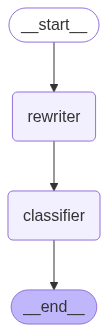

In [8]:
from IPython.display import Image, display

display(Image(enhanced_processor.get_graph().draw_mermaid_png()))